# Projeto Marinha do Brasil

## Laboratorio de Processamento de Sinais - UFRJ

#### Autor: Vinícius dos Santos Mello (viniciudsmello@poli.ufrj.br)

In [149]:
import os
import pickle
import numpy as np
import time
from keras import backend as K
import sklearn.metrics

from sklearn.externals import joblib

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions

import multiprocessing 

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 1.97887420654e-05 seconds
Time to read data file: 0.96008181572 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [150]:
%%time
# load parameters

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,
                                    n_folds=n_folds,
                                    trgt=all_trgt,
                                    dev=development_flag, verbose=False)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation
CPU times: user 5.84 ms, sys: 0 ns, total: 5.84 ms
Wall time: 7.96 ms


## Treinamento com processamento paralelo

In [151]:
%%time
# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 20
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [ ]:
%time
p = multiprocessing.Pool(processes=num_processes+2)
start_time = time.time()
folds = range(len(CVO))
neurons = range(350, 600, 25) # Train from 0 to 750
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
Neuron: 525 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 425 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 450 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 550 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 575 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 350 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 475 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 500 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 375 - Fold 1 of 2 Folds -  Init 1 of 1 Inits
Neuron: 400 - Fold 1 of 2 Folds -  Init 1 of 1 Inits


In [ ]:
print end_time/60

# Análises com variação de Neurônios

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation


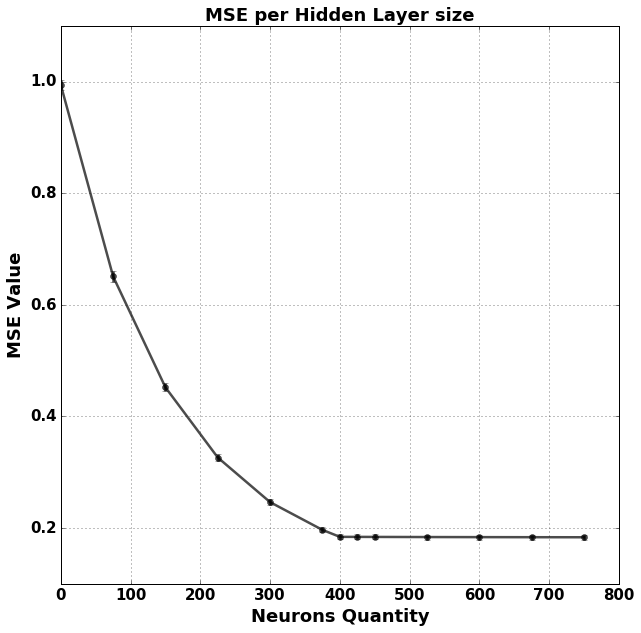

In [113]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

#os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='tanh',
                                                             n_epochs=500,
                                                             patience=50,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = range(0,825,75) + [400, 425]
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                
                p = multiprocessing.Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
print trn_params.get_params_str()

Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_relu_hidden_activation_tanh_output_activation)


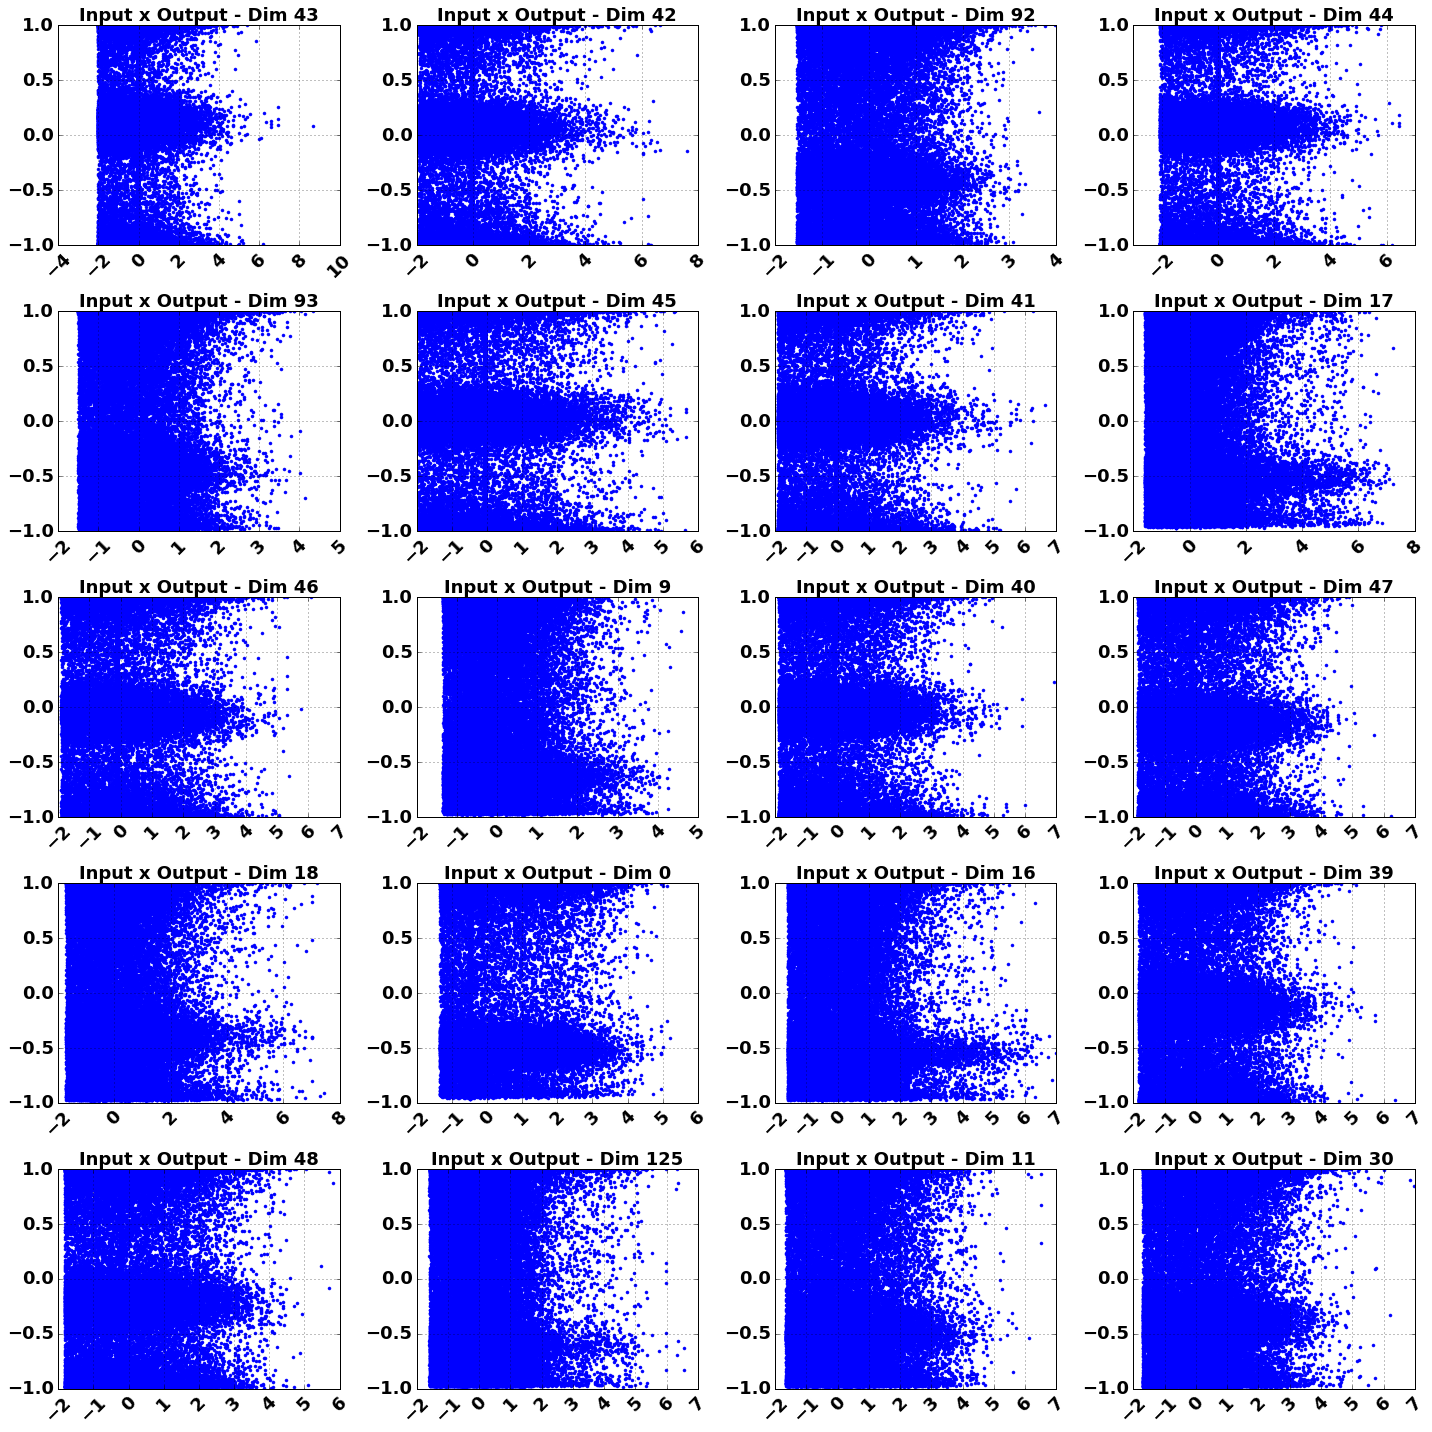

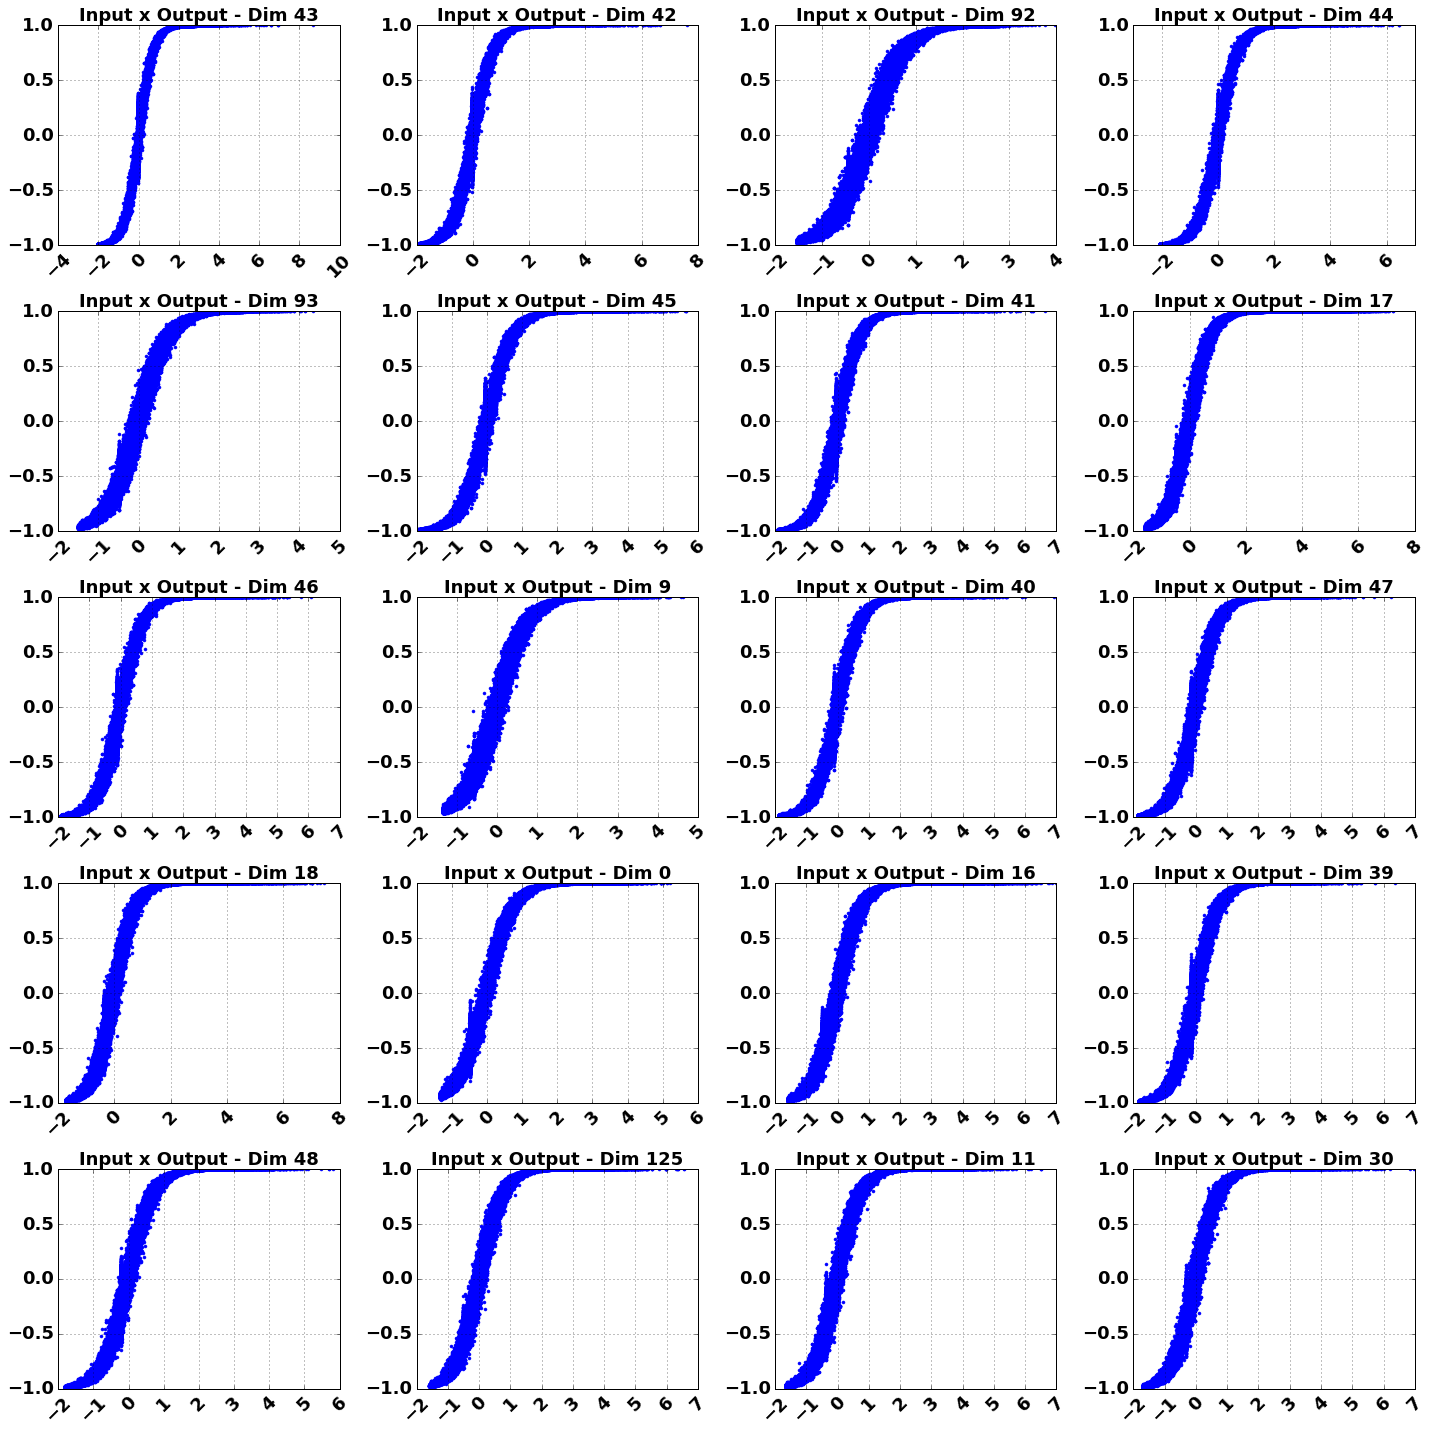

In [148]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'
# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Number of neurons at first layer
ineuron = 400 

models = {}
outputs = {}
mean = {}
indexes = {}

diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)

    if not os.path.exists(file_name):
        def trainFold(ifold):
            return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                    trgt=all_data,
                                    ifold=ifold,
                                    n_folds=n_folds, 
                                    n_neurons=ineuron,
                                    trn_params=trn_params, 
                                    save_path=results_path,
                                    dev=development_flag)
        
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    models[ifold]  = load_model(file_name)
    outputs[ifold] = models[ifold].predict(norm_data) 

    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    points = all_data.shape[0]
    # Number of dimensions to analyse
    num_dim = 20
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
    for choose_index in range(num_dim):
        ax = plt.subplot(5,4,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        plt.legend()
        plt.grid()    
        
#Save the figure
#plt.savefig(pict_results_path+'/'+current_analysis+'_%i'%ineuron+'_neurons'+trn_params.get_params_str()+'.pdf')
print "Topology (%s)"%trn_params.get_params_str()

# LOFARGram

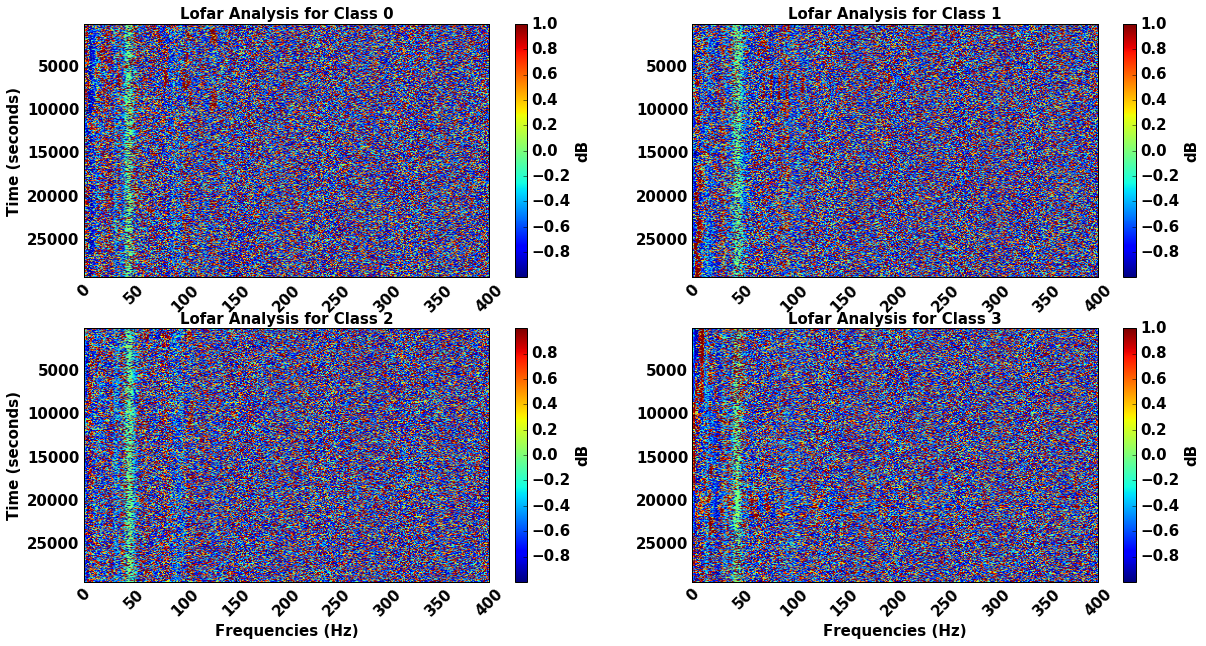

In [144]:
ifold = 1
train_id, test_id = CVO[ifold]
# normalize data based in train set
if trn_params.params['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif trn_params.params['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif trn_params.params['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

norm_data = scaler.transform(all_data)

ineuron = 300

# Get the model file
model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                           model_prefix_str,
                                           n_folds,
                                           params_str,
                                           ineuron)

if not development_flag:        
    file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
else:
    file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
model = load_model(file_name)
all_output = model.predict(norm_data)

m_fontsize = 15

fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
for iclass, class_label in enumerate(class_labels):
    ax = plt.subplot(2,2,iclass+1)
    plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

    if iclass > 1:
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
    if ((iclass == 0) or (iclass==2)):
        plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

    plt.imshow(all_output[all_trgt==iclass,:],
           cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
           aspect="auto")
    plt.xticks(np.linspace(0,400,9),rotation=45)
    cbar = plt.colorbar()
    #if ((iclass == 1) or (iclass==3)):
    cbar.ax.set_ylabel('dB',fontweight='bold') 


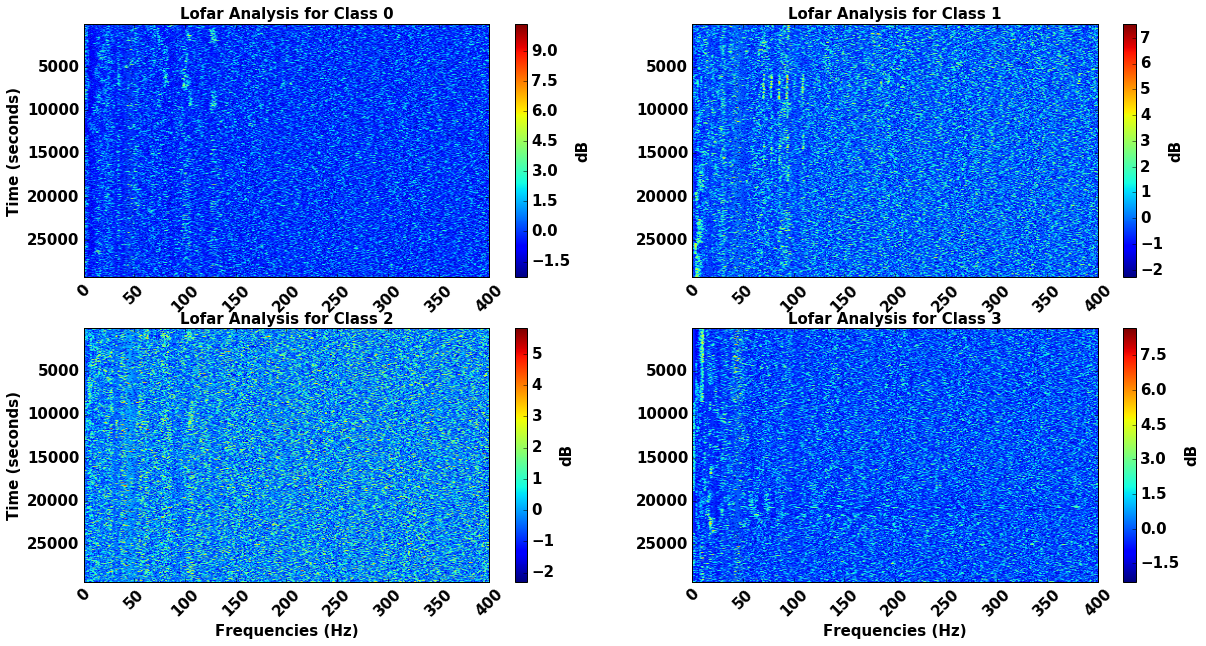

In [142]:

fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
for iclass, class_label in enumerate(class_labels):
    ax = plt.subplot(2,2,iclass+1)
    plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

    if iclass > 1:
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
    if ((iclass == 0) or (iclass==2)):
        plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

    plt.imshow(norm_data[all_trgt==iclass,:],
           cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
           aspect="auto")
    plt.xticks(np.linspace(0,400,9),rotation=45)
    cbar = plt.colorbar()
    #if ((iclass == 1) or (iclass==3)):
    cbar.ax.set_ylabel('dB',fontweight='bold') 


## Análise de Classificação para a 1º Camada

In [80]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [81]:
%time
def SAEClassificationtrainFold(ifold):
    return SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=[450],
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [82]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Fold 2 of 2 Folds -  Init 1 of 1 Inits
Fold 1 of 2 Folds -  Init 1 of 1 Inits
It took 576.924 seconds to perform the training


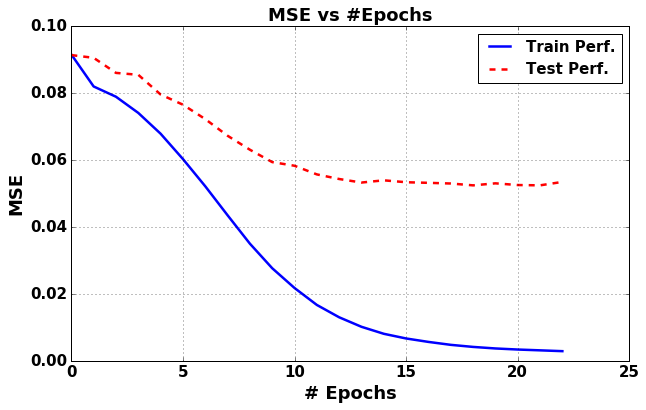

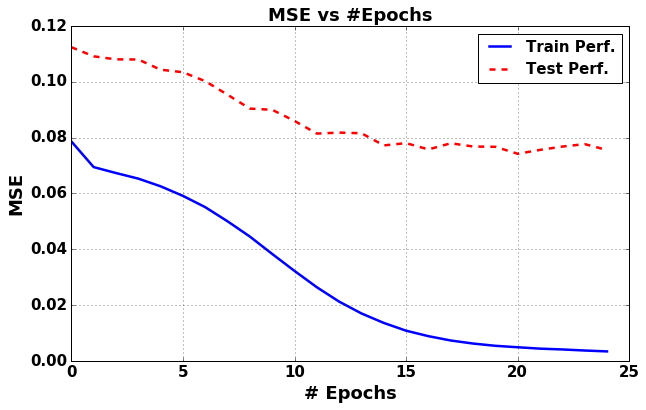

In [88]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

currentAnalysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    if model.loss == 'mean_squared_error':
        cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()


Topology (Classification_(400x450x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation)


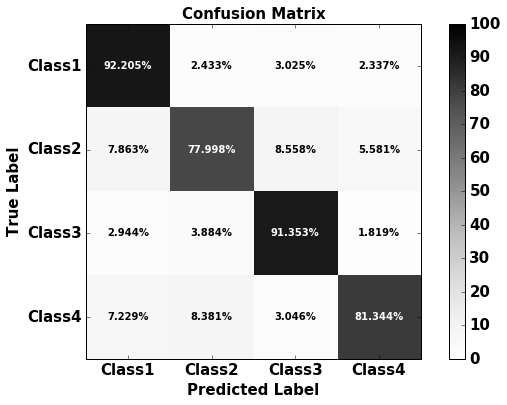

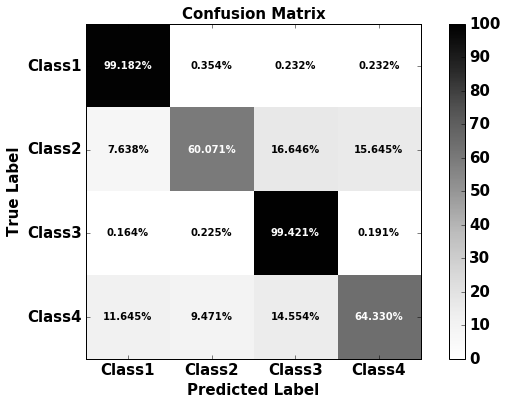

In [89]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'confusion_matrix'

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
print 'Topology (%s)'%topology

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'

# Choose Topology
hidden_neurons = [450]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=1)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()

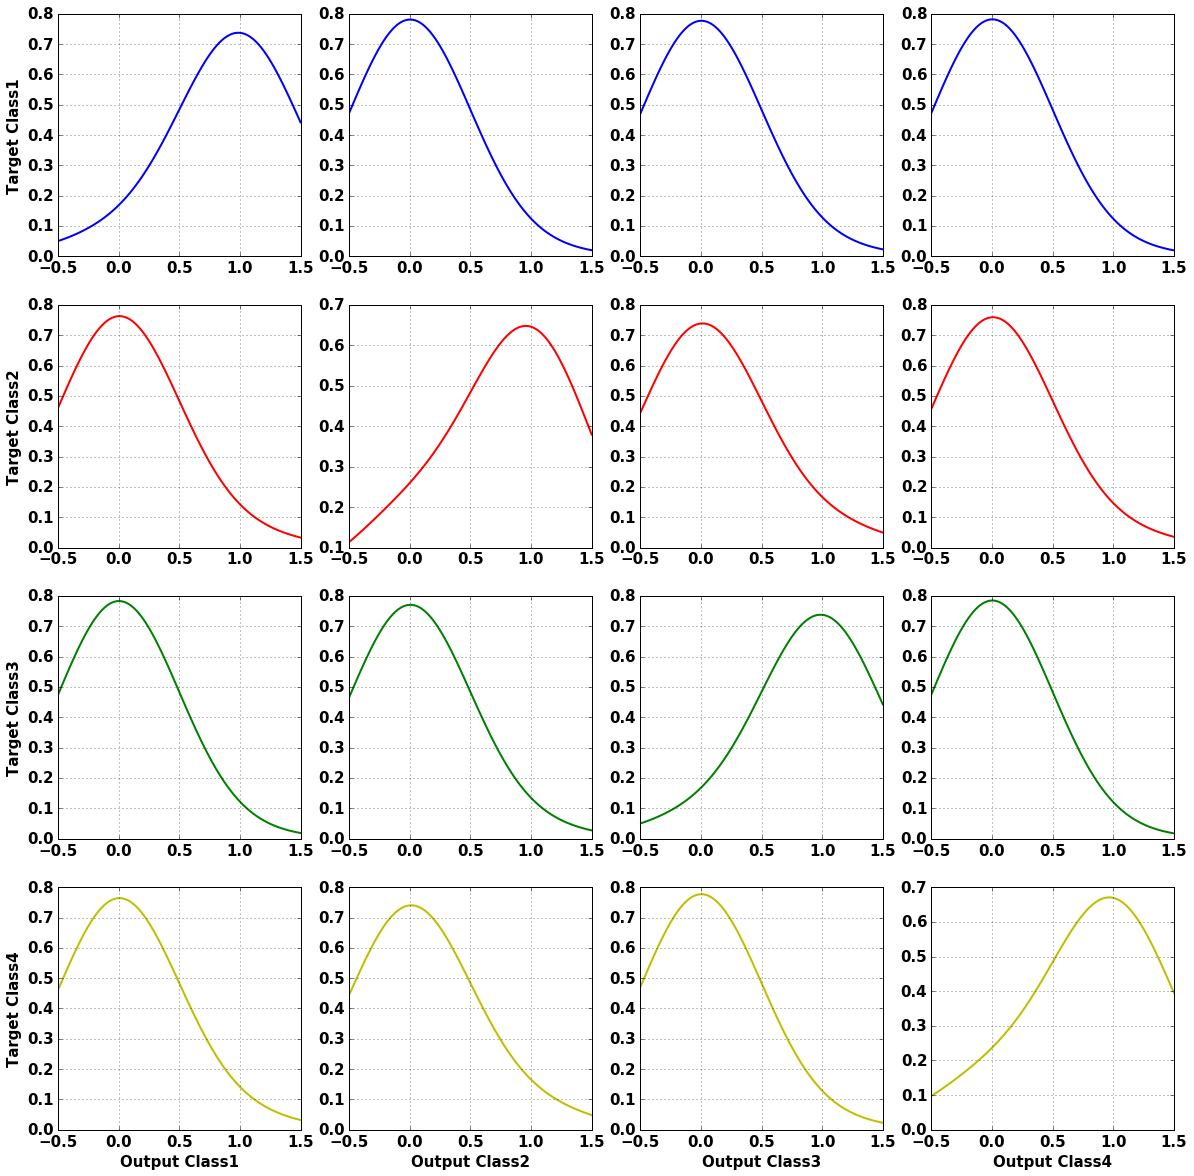

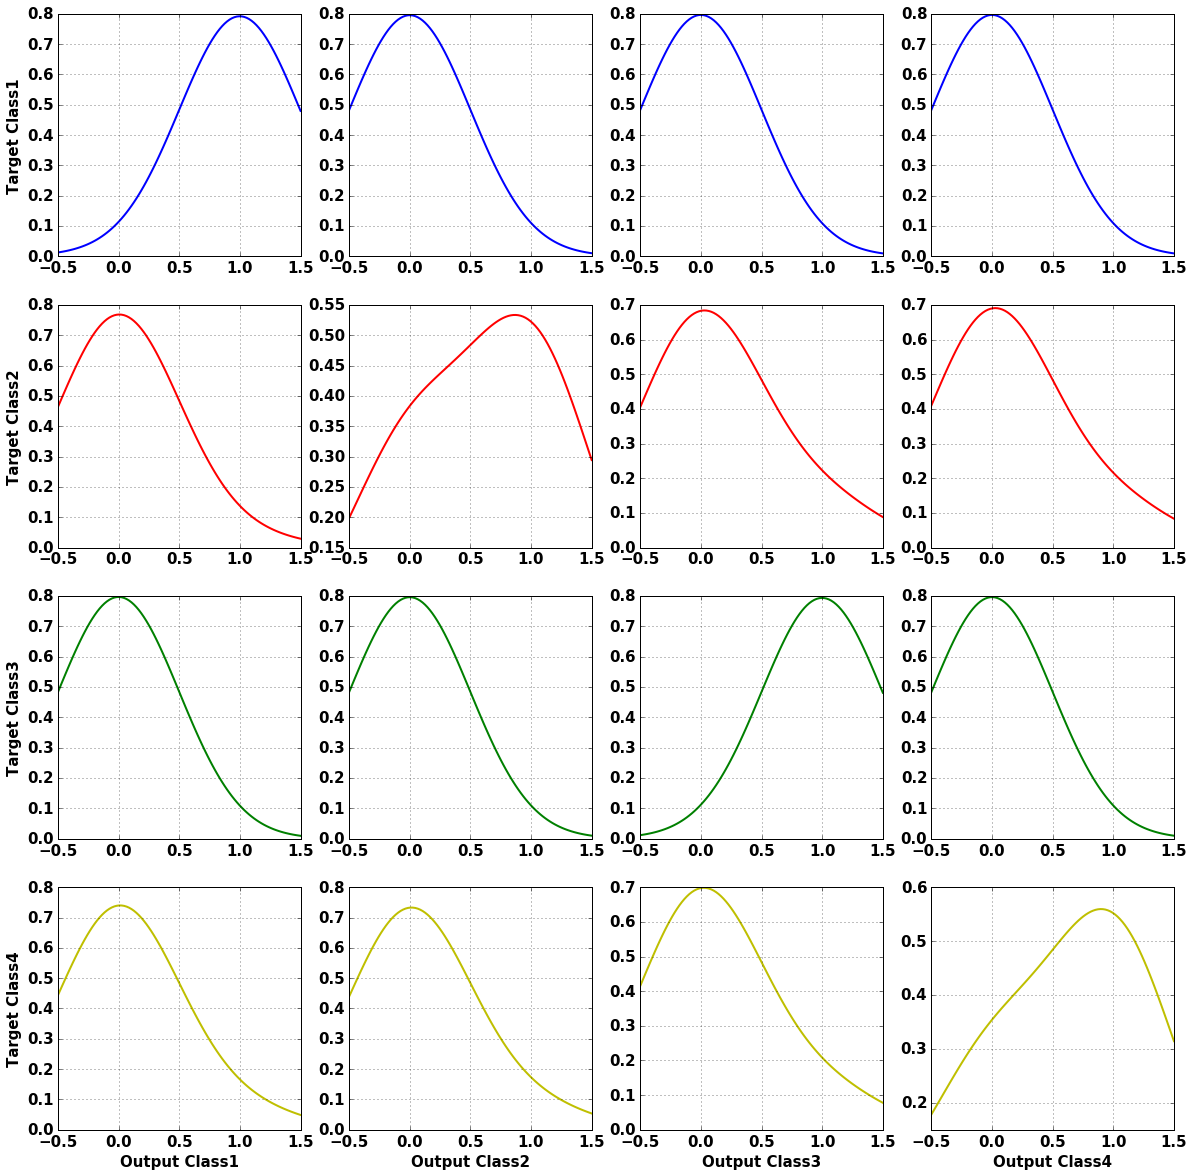

In [92]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'kernel_density'

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()

In [95]:
# Classification Report

# Choose Topology
hidden_neurons = [450]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
    #print sklearn.metrics.classification_report(trgt_sparse[test_id], np.round(output), target_names=class_labels.values())

Results for (400x450x4) neurons (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation)
	Precision	Efficiency	F1_Score
Class1:	0.883281	0.912170	0.897493

Class2:	0.841444	0.779981	0.809547

Class3:	0.861965	0.913532	0.887000

Class4:	0.893095	0.813437	0.851407

SP index: 0.924543

	Precision	Efficiency	F1_Score
Class1:	0.885292	0.991278	0.935292

Class2:	0.856671	0.600709	0.706212

Class3:	0.759790	0.994208	0.861334

Class4:	0.800153	0.643295	0.713201

SP index: 0.898539



# Treinamento da 2ª Camada

In [ ]:
%%time

prev_neurons = [450]

# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 20
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag,
                                layer = 2,
                                prev_neurons = prev_neurons)
    
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag,
                            layer = 2,
                            prev_neurons = prev_neurons)

In [ ]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))
neurons = range(0, 375, 75) # Train from 0 to 750
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

   # Análise da variação do númeor de neurônios na segunda camada

In [ ]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

#os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='tanh',
                                                             n_epochs=500,
                                                             patience=50,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = range(0,825,75) + [400, 425]
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                
                p = multiprocessing.Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
print trn_params.get_params_str()

In [ ]:
# analysis example - number epochs

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_epochs_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    
    epochs_mat = range(1,10,1)
    mse_mat = np.zeros([n_folds,len(epochs_mat)])
    
    for iepochs,epochs_value in enumerate(epochs_mat):       
        print "Number of Epochs:", epochs_value
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='softplus',
                                                         output_activation='softmax',
                                                         patience=50,
                                                         batch_size=512,
                                                         n_epochs=epochs_value)
    
        params_str = trn_params.get_params_str()
        print "params_str: ",params_str
        n_folds = 2
        CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)


        for ifold in range(len(CVO)):
            train_id, test_id = CVO[ifold]

            # normalize data based in train set
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

            norm_data = scaler.transform(all_data)
            
            neurons =10
            NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                                n_neurons=neurons, trn_params=trn_params, 
                                save_path=results_path,dev=True)

            # turn targets in sparse mode
            trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))


            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           neurons)

            model = Sequential()
            model.add(Dense(neurons, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
                
            print 'Model name: %s'%(file_name)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = np.mean(np.sum((trgt_sparse-output)**2))
            mse_mat[ifold,iepochs] = mse
    joblib.dump([mse_mat,epochs_mat],analysis_file_name,compress=9)
else:
    [mse_mat,epochs_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(epochs_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)
ax.set_title('MSE per Number of Epochs',fontsize=18,weight='bold')
ax.set_xlabel('Epochs',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold')